In [76]:
#look at the highest multicorrelated features (apart from lifespan)
#exercise-genetic -0.035
#exercise-smoking 0.021 (smoking a positive correlation with exercise?)
#exercise-alcohol -0.024

In [77]:
# all libraries required for the entire EDA

from requests import get
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Samuel Norman "Sam" Seaborn is a fictional character portrayed by Rob Lowe on the television serial drama The West Wing. Hence: sns
from seaborn_qqplot import pplot
import pandas as pd

import datetime as dt
from scipy import stats
from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

%matplotlib inline
sns.set(color_codes=True)

In [78]:
df_raw= pd.read_csv('df4.csv',sep=',',skipinitialspace=True)

In [79]:
df_raw = df_raw.drop(columns='Unnamed: 0')
df_raw.head()

genetic  length   mass  exercise  smoking  alcohol  lifespan  sugar   bmi
0     73.9   185.0   99.7       0.9      0.0      2.4      73.1    6.9  29.1
1     86.0   172.0  105.4       1.8      8.1      0.4      85.0    4.2  35.6
2     83.3   176.0  111.4       1.1      0.8      4.6      81.6    7.5  36.0
3     82.8   164.0  111.4       4.7     11.8      1.0      81.0    2.9  41.4
4     78.7   178.0   71.6       1.5      8.3      4.9      75.0    5.5  22.6

In [80]:
df_raw.columns

Index(['genetic', 'length', 'mass', 'exercise', 'smoking', 'alcohol',
       'lifespan', 'sugar', 'bmi'],
      dtype='object')

In [81]:
analysis_df = df_raw[['genetic', #'length', 'mass', 
                      'exercise', 'smoking', 'alcohol', 
                      #'sugar','lifespan'
                      ]]
analysis_df.head()

genetic  exercise  smoking  alcohol
0     73.9       0.9      0.0      2.4
1     86.0       1.8      8.1      0.4
2     83.3       1.1      0.8      4.6
3     82.8       4.7     11.8      1.0
4     78.7       1.5      8.3      4.9

In [82]:
#colorfull matrix, showing correlations
df_corr = analysis_df.dropna().corr()
df_corr.style.background_gradient(cmap='RdBu')

In [83]:
# #Quick Overall Graphical Overview (!warning, takes ~2min or more)
# g = sns.PairGrid(analysis_df)
# g.map(sns.lineplot)

In [84]:
def pearonsstats(pipe):
    r, p = stats.pearsonr(analysis_df.exercise, analysis_df[pipe])
    print(f'{pipe} corr:', round(r, 4)) 
    print(f'{pipe} p-val:', round(p, 4))

pearonsstats('smoking')
pearonsstats('alcohol')
pearonsstats('genetic')

smoking corr: 0.0274
smoking p-val: 0.0837
alcohol corr: -0.0204
alcohol p-val: 0.1978
genetic corr: -0.0452
genetic p-val: 0.0044


Rejected smoking and alcohol as linear correlation between exercise, only genetic has linear corr and valid p-value<br>
lets look at the graph:

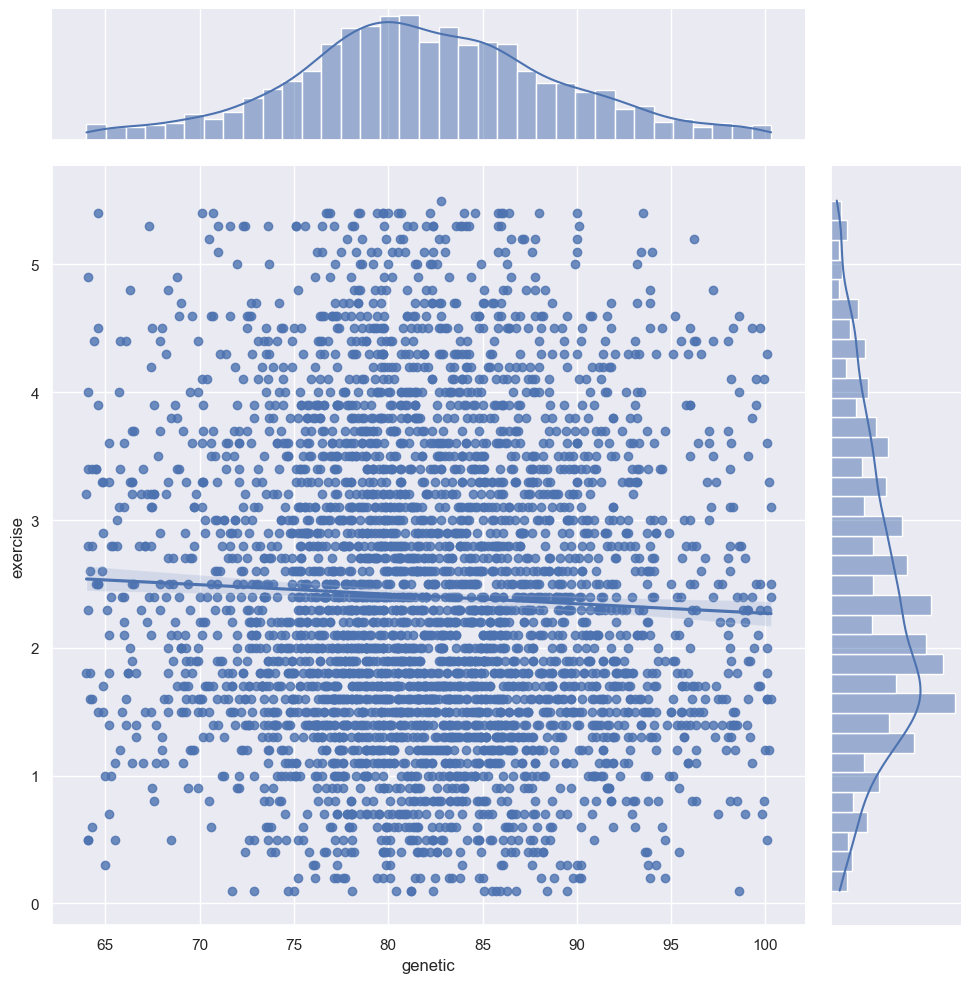

In [85]:
#jointplot with distribution and regression line
sns.jointplot(data=analysis_df, x='genetic', y="exercise",marginal_kws=dict(bins=35), kind='reg',height=10) #height instead of figsize (square)


A really tiny slope, for exercise sake we assume its negative linear in the graph and continue

<h3>Greedy Elimination</h3>
if genetic and exercise are correlated then the feature with the lowest correlation to lifespan is eliminated in this case exercise with 0.08 will be removed (genetic = 0.92)

Lets see if there is a difference in regression accuracy (with and without exercise)

In [86]:
from sklearn import linear_model 
from sklearn.model_selection import train_test_split

In [87]:
df_raw.columns

Index(['genetic', 'length', 'mass', 'exercise', 'smoking', 'alcohol',
       'lifespan', 'sugar', 'bmi'],
      dtype='object')

In [88]:
temp = df_raw

train, test = train_test_split(temp, test_size=0.2, random_state=0)

X = train[['genetic', 'length', 'mass', 'exercise', 'smoking', 'alcohol', 'sugar','bmi']]
y = train.lifespan
regr = linear_model.LinearRegression()
regr.fit(X, y) 
score = regr.score(test[['genetic', 'length', 'mass', 'exercise', 'smoking', 'alcohol', 'sugar','bmi']],test.lifespan)
print(f'coefficient of determination(R\N{SUPERSCRIPT TWO}) with exercise:', score)

coefficient of determination(R²) with exercise: 0.9792571387182405


In [91]:
temp = df_raw

train, test = train_test_split(temp, test_size=0.2, random_state=0)

X = train[['genetic', 'length', 'mass', 'smoking', 'alcohol', 'sugar','bmi']]
y = train.lifespan
regr = linear_model.LinearRegression()
regr.fit(X, y) 
score = regr.score(test[['genetic', 'length', 'mass', 'smoking', 'alcohol', 'sugar','bmi']],test.lifespan)
print(f'coefficient of determination(R\N{SUPERSCRIPT TWO})without exercise:', score)

coefficient of determination(R²)without exercise: 0.963087002111707


In [92]:
from sklearn.metrics import mean_squared_error
import math
p_test = regr.predict(test.drop(columns=['lifespan','exercise']))
mse = mean_squared_error(test.lifespan, p_test)
rmse = (math.sqrt(mse))
print('RMSE:',rmse)

RMSE: 1.4474751925341771


Deleting the slightly multicorrelated exercise reduced accuracy of the model therefore we conclude it improves the model and decide to keep exercise despite being multicorrelated <br>
> Reference: "The fact that some or all predictor variables are correlated among themselves does not, in general, inhibit our ability to obtain a good fit nor does it tend to affect inferences about mean responses or predictions of new observations." — Applied Linear Statistical Models, p289, 4th Edition